# Advanced Databases Project Phase 1
Academic Year: 2024/2025 <br>
Authors: Diogo Barreta 64560, Muhammed Jaabir Mohamed Zifri 64912, Josè Dalla Torre 64672

## Setup
First we need to install all the necessary packages.

In [105]:
!pip install pandas
!pip install mysql-connector-python
!pip install matplotlib
!pip install pymongo
!pip install sqlalchemy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Data visualization
Before starting to clean the data we need to load the csv as dataframe. <br>
After that we display the first rows to see the format of the data.

In [106]:
import pandas as pd
import numpy as np
n_rows = 50000
folder_name = 'archive'
cards_df = pd.read_csv(f'{folder_name}/cards_data.csv',nrows=n_rows)
transactions_df = pd.read_csv(f'{folder_name}/transactions_data.csv',nrows=n_rows)
users_df = pd.read_csv(f'{folder_name}/users_data.csv',nrows=n_rows)

In [107]:
cards_df.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [108]:
transactions_df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [109]:
users_df.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


### Missing Data
After the first exploration of the data we want to see if there are any missing values. <br>
To have a better understanding of the distribution of the values we use a countplot for every column of the dataframe.

<Figure size 640x480 with 0 Axes>

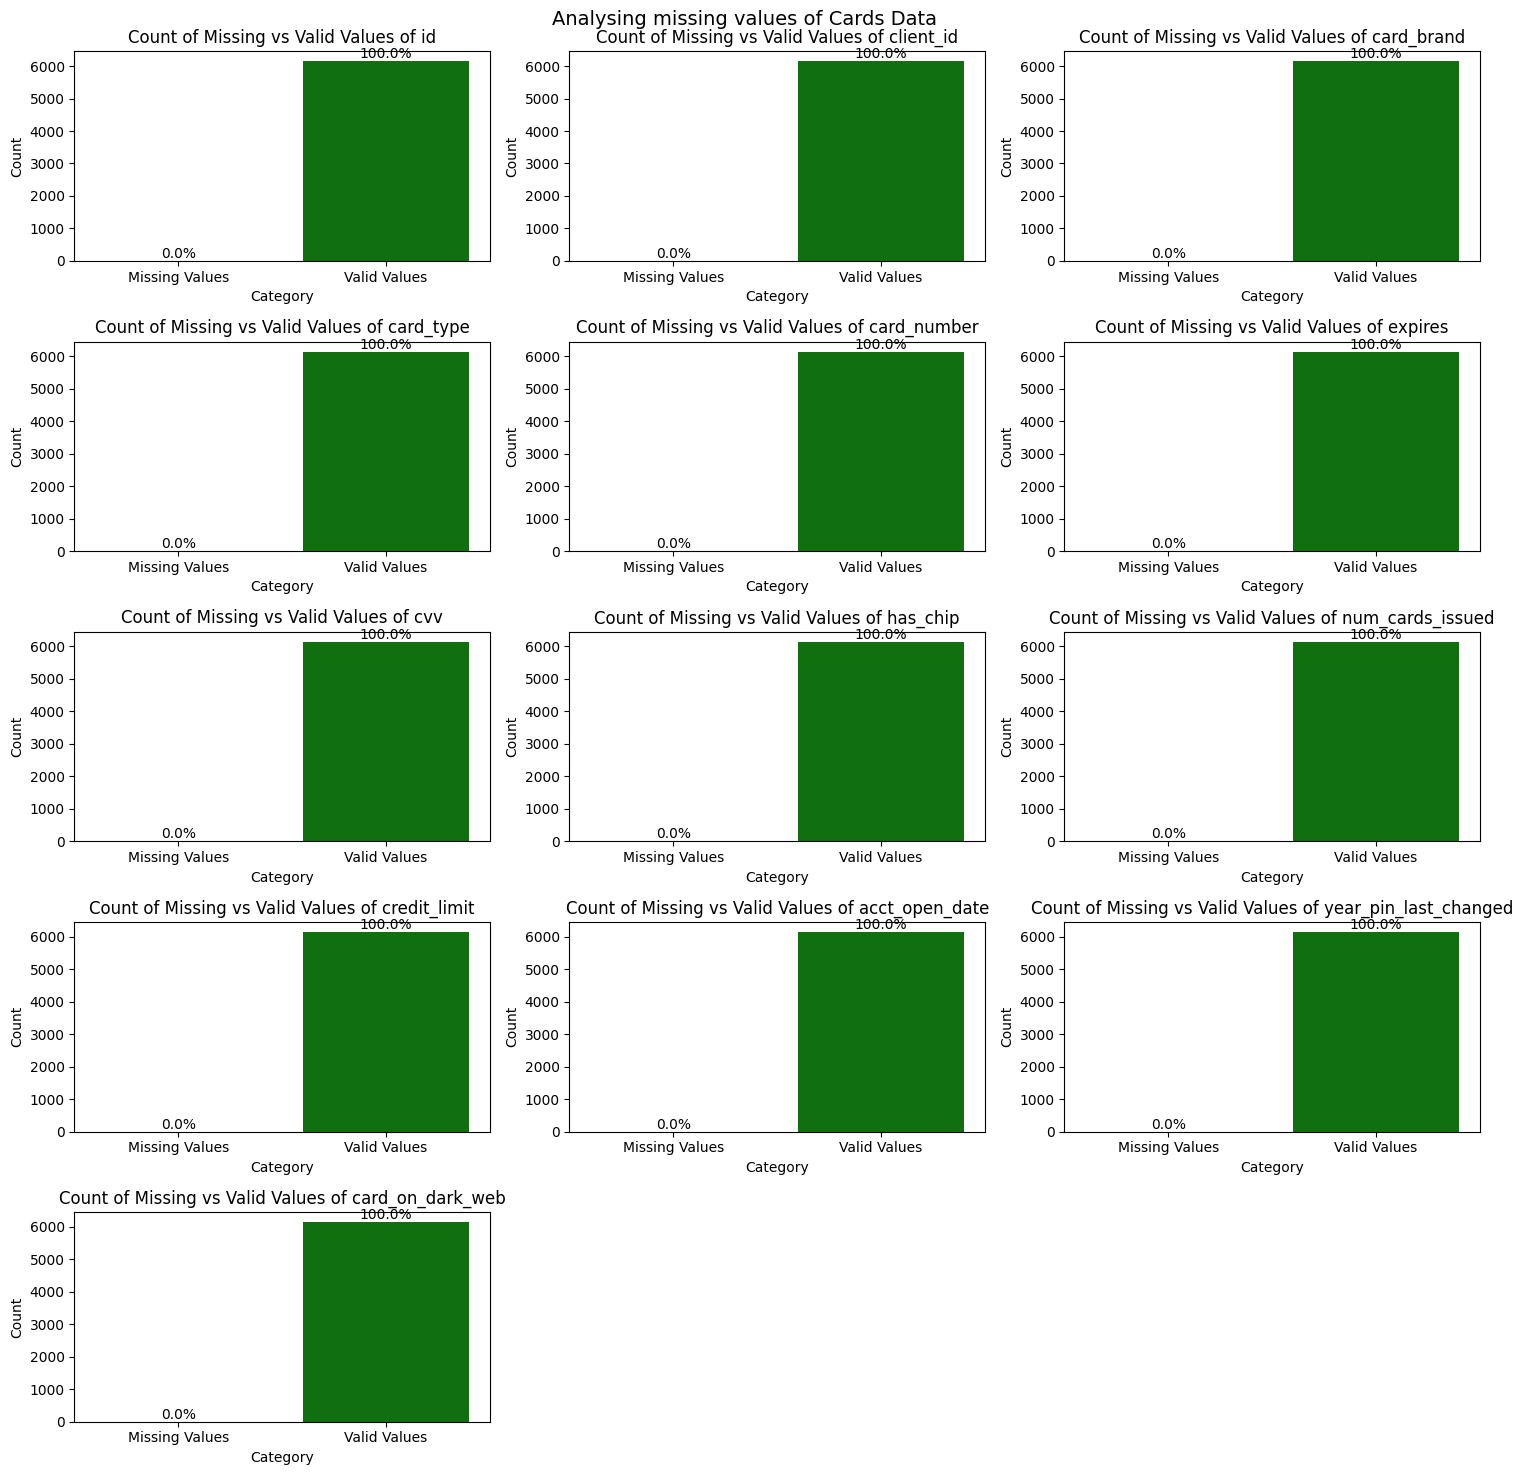

<Figure size 640x480 with 0 Axes>

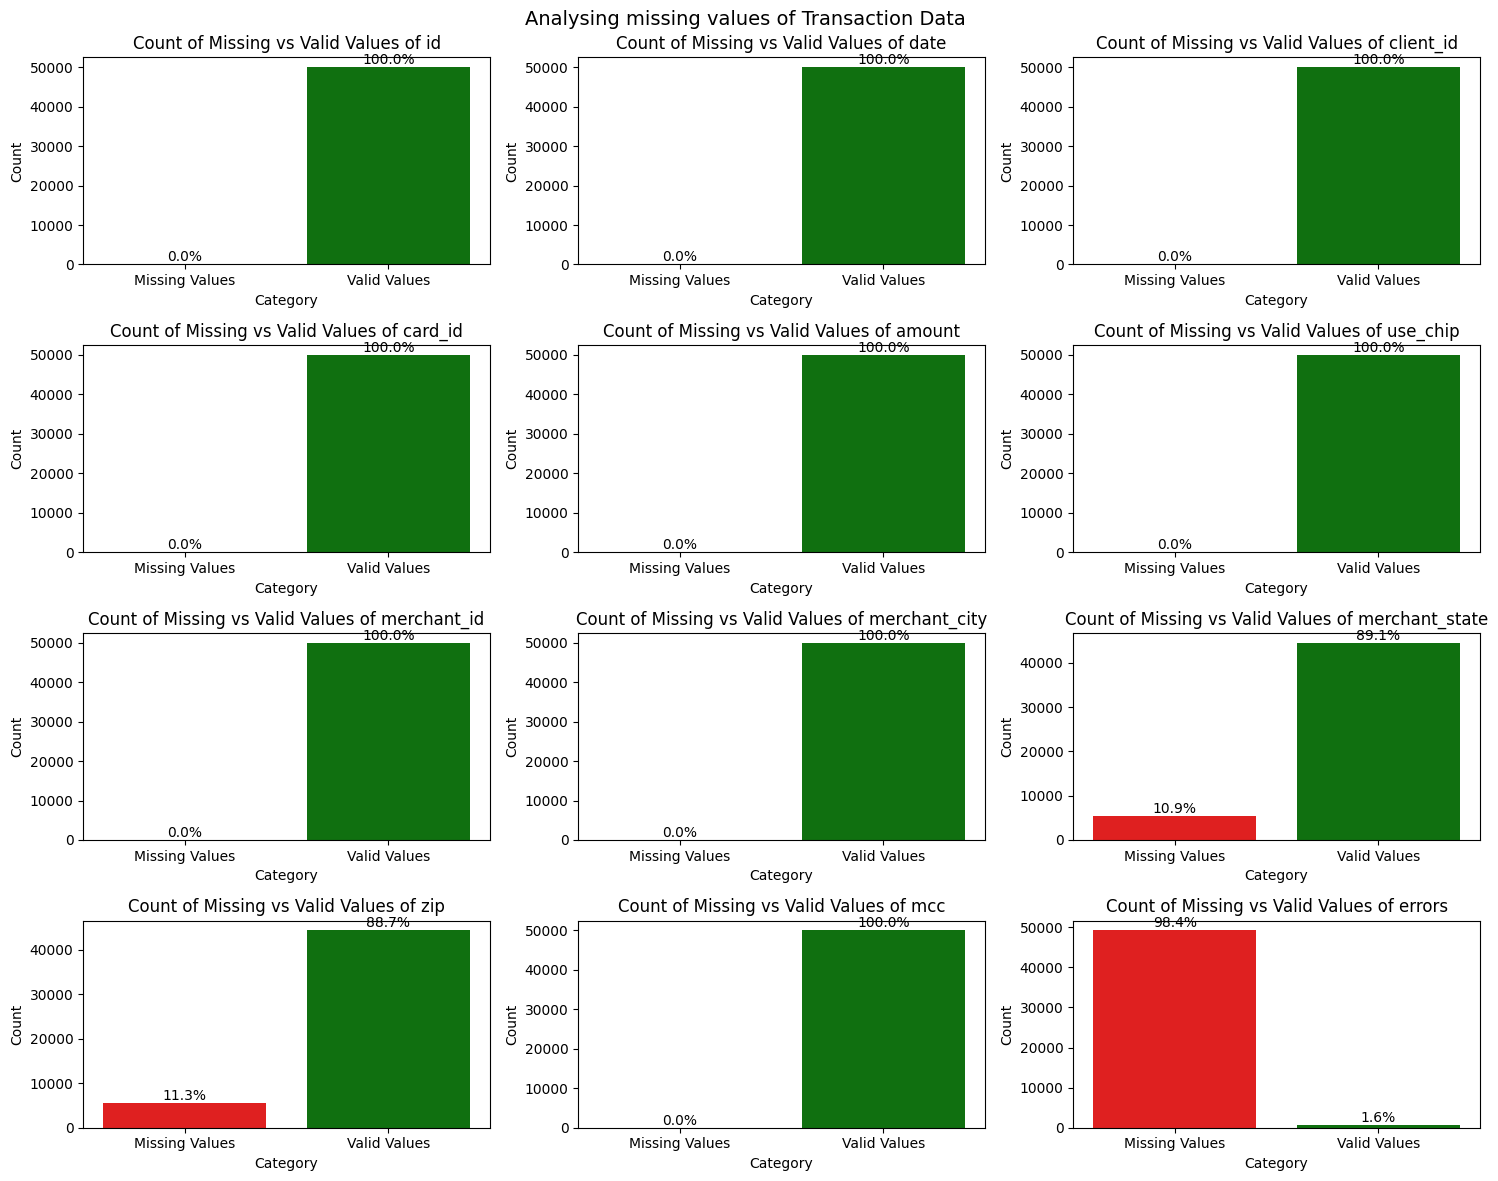

<Figure size 640x480 with 0 Axes>

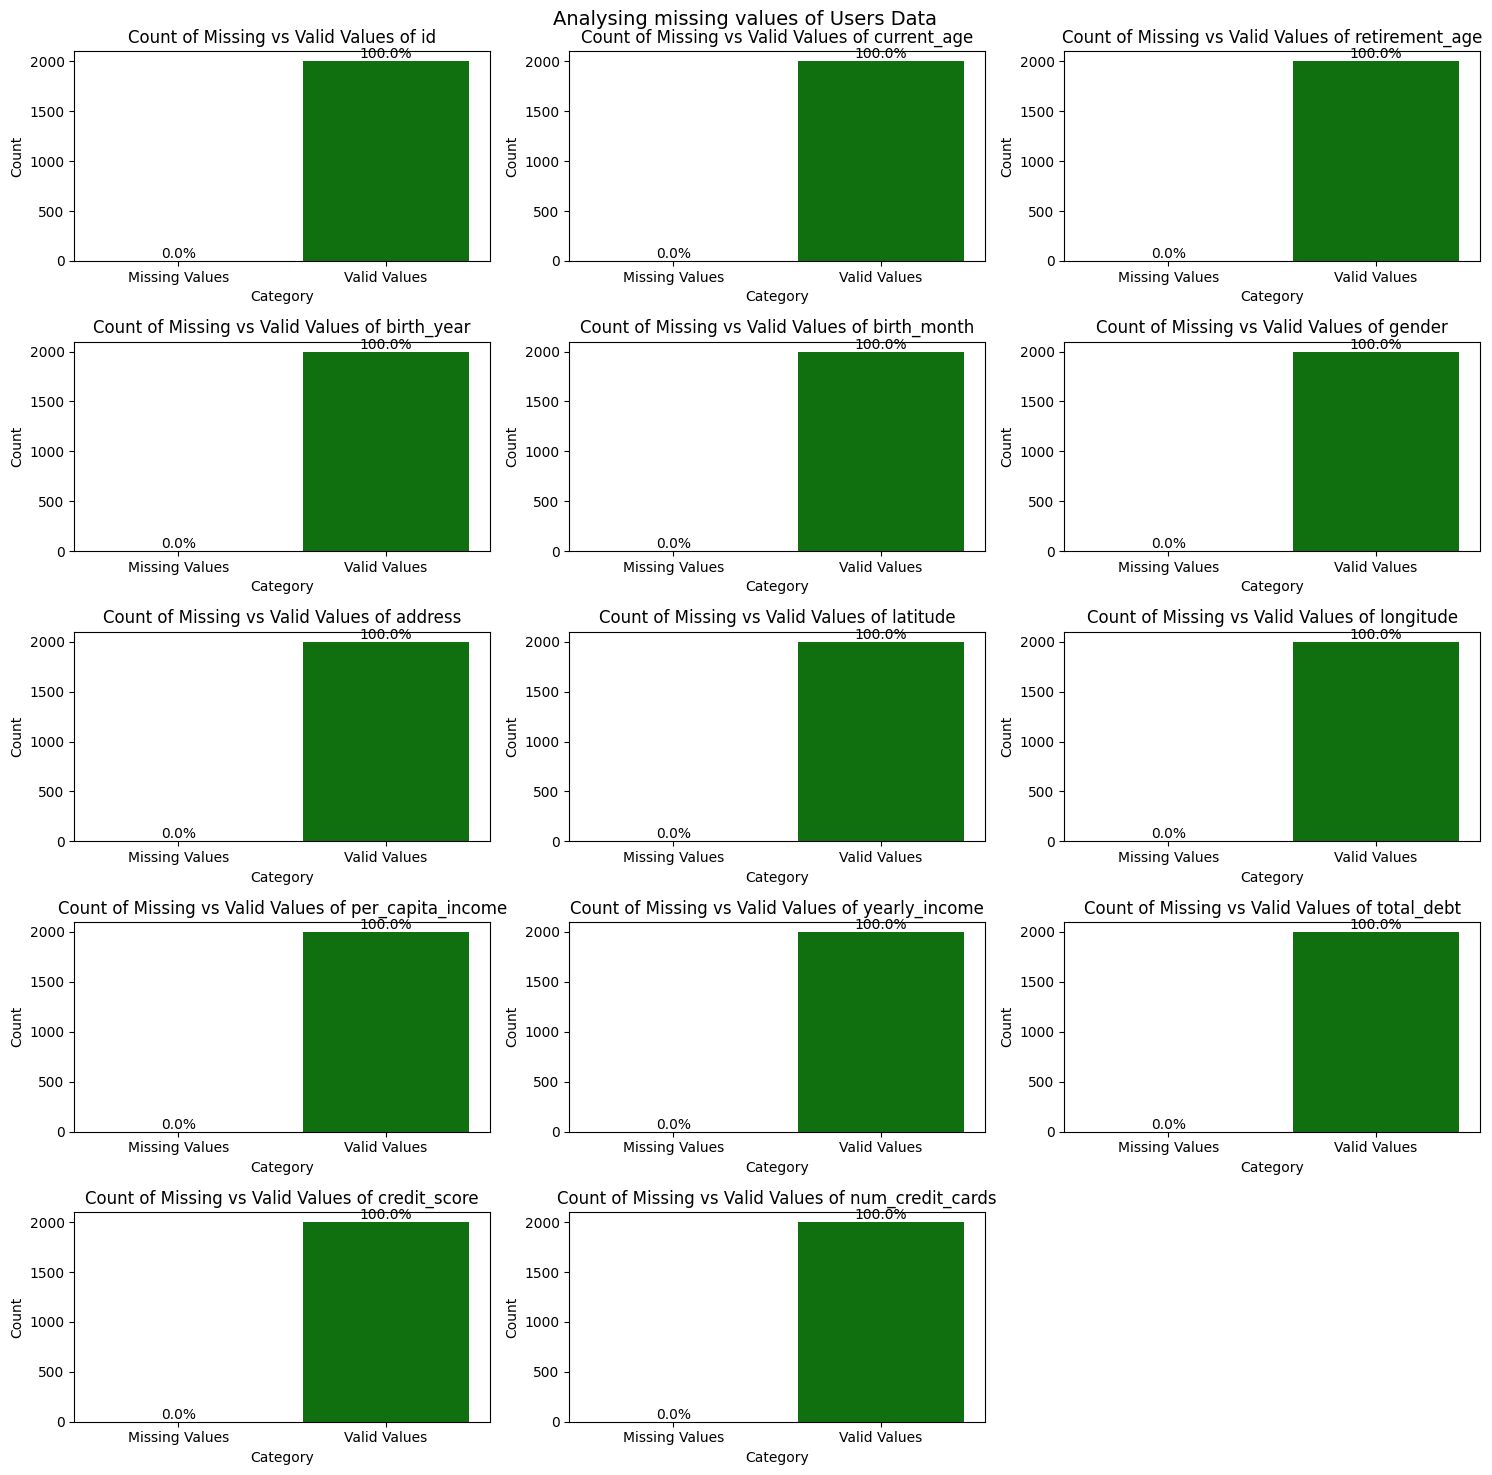

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

def create_plot(df: pd.DataFrame, df_name:str)-> None:
    n_cols = 3
    n_rows = math.ceil(len(df.columns) / n_cols)
    plt.tight_layout()
    plt.figure(figsize=(15, n_rows * 3))
    for i,column in enumerate(df.columns,1):
        # Count missing and valid values
        total = len(df[column])
        missing_count = df[column].isna().sum()
        valid_count = df[column].notna().sum()

        # Prepare data for plotting
        plot_data = pd.DataFrame({
            'Category': ['Missing Values', 'Valid Values'],
            'Count': [missing_count, valid_count]
        })
        # Create the 
        plt.suptitle(f"Analysing missing values of {df_name}", fontsize=14)
        # Create the countplot
        ax = plt.subplot(n_rows,n_cols,i)
        sns.barplot(data=plot_data, x='Category', y='Count',hue='Category', palette=['red', 'green'])
        plt.title(f"Count of Missing vs Valid Values of {column}")
        plt.ylabel('Count')
        plt.xlabel('Category')
        for c in ax.containers:
            ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    plt.tight_layout()
    plt.show()

create_plot(cards_df, "Cards Data")
create_plot(transactions_df, "Transaction Data")
create_plot(users_df, "Users Data")

## Data Cleaning
We can see that only the transactions data has missing values. <br>
First we remove from the users data the unnecessary string like the dollar sign, then we convert all the column to the same value based on data present.

In [111]:
remove_currency = lambda x: float(x.replace("$","").strip())
users_df["per_capita_income"] = users_df["per_capita_income"].apply(remove_currency)
users_df["yearly_income"] = users_df["yearly_income"].apply(remove_currency)
users_df["total_debt"] = users_df["total_debt"].apply(remove_currency)
users_df["gender"] = users_df["gender"].astype("string")
users_df["address"] = users_df["address"].astype("string")
users_df.dtypes

id                            int64
current_age                   int64
retirement_age                int64
birth_year                    int64
birth_month                   int64
gender               string[python]
address              string[python]
latitude                    float64
longitude                   float64
per_capita_income           float64
yearly_income               float64
total_debt                  float64
credit_score                  int64
num_credit_cards              int64
dtype: object

We apply the same logic to the cards dataframe. <br>
We decided to convert from "YES" or "NO" to boolean value to simplify the insertion in the database later. <br>
Also we decided to convert the date to the Datetime of pandas <br>

In [112]:
cards_df["credit_limit"] = cards_df["credit_limit"].apply(remove_currency)
cards_df["has_chip"] = cards_df["has_chip"].replace({"YES": True, "NO": False})
cards_df["card_on_dark_web"] = cards_df["card_on_dark_web"].replace({"Yes": True, "No": False})
cards_df["card_brand"] = cards_df["card_brand"].astype("string")
cards_df["card_type"] = cards_df["card_type"].astype("string")
cards_df["card_number"] = cards_df["card_number"].astype("string")
cards_df["expires"] = pd.to_datetime(cards_df["expires"])
cards_df["acct_open_date"] = pd.to_datetime(cards_df["acct_open_date"])
cards_df.dtypes

/tmp/ipykernel_384736/1931433102.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cards_df["has_chip"] = cards_df["has_chip"].replace({"YES": True, "NO": False})
/tmp/ipykernel_384736/1931433102.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cards_df["card_on_dark_web"] = cards_df["card_on_dark_web"].replace({"Yes": True, "No": False})
/tmp/ipykernel_384736/1931433102.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-ex

id                                int64
client_id                         int64
card_brand               string[python]
card_type                string[python]
card_number              string[python]
expires                  datetime64[ns]
cvv                               int64
has_chip                           bool
num_cards_issued                  int64
credit_limit                    float64
acct_open_date           datetime64[ns]
year_pin_last_changed             int64
card_on_dark_web                   bool
dtype: object

Now it's time to clean the dataframe that contains the data about the transactions. <br>
We decided to fill the missing data of the **merchant_state** column as "Unkown" to prevent missing values. <br>
We decided to fill the missing data of the **zip** column as "0" to prevent missing values. <br>
We decided to fill the missing data of the **errors** column as "No Errors" to prevent missing values. <br>

In [113]:
transactions_df["amount"] = transactions_df["amount"].apply(remove_currency)
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
transactions_df["use_chip"] = transactions_df["use_chip"].astype("string")
transactions_df["merchant_city"] = transactions_df["merchant_city"].astype("string")
transactions_df["merchant_state"] = transactions_df["merchant_state"].astype("string")
transactions_df["merchant_state"] = transactions_df["merchant_state"].fillna('Unknown')
transactions_df['zip'] = transactions_df["zip"].fillna('0')
transactions_df['zip'] = transactions_df["zip"].astype(np.float64)
transactions_df["errors"] = transactions_df["errors"].astype("string")
transactions_df["errors"] = transactions_df["errors"].fillna("No Errors")
transactions_df.dtypes

id                         int64
date              datetime64[ns]
client_id                  int64
card_id                    int64
amount                   float64
use_chip          string[python]
merchant_id                int64
merchant_city     string[python]
merchant_state    string[python]
zip                      float64
mcc                        int64
errors            string[python]
dtype: object

We have manually changed few rows to work with one of the operations on the cards dataset by randomly assinging the value to True for `card_on_dark_web` column.

In [114]:
card_ids = transactions_df[transactions_df['amount'] > 1000].sample(10)['card_id'].unique()
cards_df.loc[cards_df['id'].isin(card_ids), 'card_on_dark_web'] = True
cards_df.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,2022-12-01,623,True,2,24295.0,2002-09-01,2008,False
1,2731,825,Visa,Debit,4956965974959986,2020-12-01,393,True,2,21968.0,2014-04-01,2014,False
2,3701,825,Visa,Debit,4582313478255491,2024-02-01,719,True,2,46414.0,2003-07-01,2004,False
3,42,825,Visa,Credit,4879494103069057,2024-08-01,693,False,1,12400.0,2003-01-01,2012,False
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,2009-03-01,75,True,1,28.0,2008-09-01,2009,False


In [115]:
cards_df[cards_df.card_on_dark_web == True].shape

(10, 13)

## MySQL
This section is dedicated to the definition of the tables, insertion and queries of the MySQL database.

### Setup
Since the components of the group are coding on different machine we decided to use a file called ".env" to store the configurations for the databases. <br>
The code to load the configuration is reported below

In [116]:
import dotenv
import os
import mysql.connector
## database initialization
dotenv.load_dotenv()
database_name = 'group25'

MYSQL_CONFIG = {
    'username': os.environ['mysql_username'],
    'password': os.environ['mysql_password'],
    'host'    : os.environ['mysql_hostname'],
    'database_name' : database_name
}
# Create Connection
connection = mysql.connector.connect(
  host=MYSQL_CONFIG["host"],
  user=MYSQL_CONFIG["username"],
  password=MYSQL_CONFIG["password"]
)
db_url = f"mysql+mysqlconnector://{MYSQL_CONFIG['username']}:{MYSQL_CONFIG['password']}@{MYSQL_CONFIG['host']}:3306/{database_name}"

### Insertion into MySQL
Before we delete the database and the tables to make sure that we can create them correctly

In [117]:
cursor = connection.cursor()
cursor.execute(f"DROP DATABASE IF EXISTS {database_name}")
cursor.execute(f"CREATE DATABASE IF NOT EXISTS {database_name}")
cursor.execute(f"USE {database_name}")


cursor.execute(f"DROP TABLE IF EXISTS users")
cursor.execute("""
CREATE TABLE IF NOT EXISTS users (
              id INT PRIMARY KEY,
              current_age INT,
              retirement_age INT,
              birth_year INT,
              birth_month INT,
              gender VARCHAR(255),
              address VARCHAR(255),
              latitude DECIMAL,
              longitude DECIMAL,
              per_capita_income DECIMAL,
              yearly_income DECIMAL,
              total_debt DECIMAL,
              credit_score INT,
              num_credit_cards INT
);
""")

cursor.execute(f"DROP TABLE IF EXISTS cards")
cursor.execute("""
CREATE TABLE IF NOT EXISTS cards (
      id INT PRIMARY KEY,
      client_id INT,
      card_brand VARCHAR(255),
      card_type VARCHAR(255),
      card_number VARCHAR(255),
      expires DATETIME,
      cvv INT,
      has_chip BOOLEAN,
      num_cards_issued INT,
      credit_limit DECIMAL,
      acct_open_date DATETIME,
      year_pin_last_changed INT,
      card_on_dark_web BOOLEAN,
      FOREIGN KEY (client_id) REFERENCES users(id)
);
""")

cursor.execute(f"DROP TABLE IF EXISTS transactions")
cursor.execute("""
CREATE TABLE IF NOT EXISTS transactions (
    id INT PRIMARY KEY,
    date DATETIME,
    client_id INT,
    card_id INT,
    amount DECIMAL,
    use_chip VARCHAR(255),
    merchant_id INT,
    merchant_city VARCHAR(255),
    merchant_state VARCHAR(255),
    zip DECIMAL,
    mcc INT,
    errors VARCHAR(255),
    FOREIGN KEY (client_id) REFERENCES users(id),
    FOREIGN KEY (card_id) REFERENCES cards(id)
);
""")
 

connection.commit()
cursor.execute("SHOW TABLES")
for table in cursor:
    print(table)

('cards',)
('transactions',)
('users',)


### Populate the Database
After that we populate the database as seen in class. <br>
We keep track of the time to compare later with the mongodb

In [118]:
from sqlalchemy import create_engine, text
import time
mysql_times = []
engine = create_engine(db_url)
start_time = time.time()
users_df.to_sql('users', con=engine, if_exists='append', index=False, method='multi')
cards_df.to_sql('cards', con=engine, if_exists='append', index=False, method='multi')
transactions_df.to_sql('transactions', con=engine, if_exists='append', index=False, method='multi')
end_time = time.time()
mysql_times.append(end_time - start_time)
print("Data inserted into MySQL")

Data inserted into MySQL


### Queries
Now we define the queries with a short description to help the reader

In [119]:
queries = []

In [120]:
q1 = {
    "id": 1,
    "description":"Select users with a credit score greater than 750.",
    "query" : "SELECT id, current_age, yearly_income, credit_score FROM users WHERE credit_score > 750;"
    }
queries.append(q1)

In [121]:
q2 ={
    "id": 2,
    "description" :"Select all transactions where errors occurred.",
    "query" : "SELECT id, date, card_id, amount, errors FROM transactions WHERE errors != 'No Errors';"
}
queries.append(q2)

We create a table to store the results of the third operation.

In [122]:
cursor.execute(f"DROP TABLE IF EXISTS state_spending_summary")
cursor.execute('''CREATE TABLE IF NOT EXISTS state_spending_summary (
    state VARCHAR(255),
    total_spent DECIMAL );'''
)

In [123]:
q3 ={
    "id": 3,
    "description": "Insert the total transaction amount per state for female users.",
    "query" : """
    INSERT INTO state_spending_summary (state, total_spent)
    SELECT T.merchant_state, SUM(T.amount) AS total_spent 
    FROM transactions T
    JOIN users U ON T.client_id = U.id
    WHERE U.gender = 'Female'
    GROUP BY T.merchant_state;
    """
}
queries.append(q3)  

In [124]:
q3_query = {
    "description": "Select all from the state spending summary",
     "query" : """SELECT *
     FROM state_spending_summary;"""
}

In [125]:
q4 = {
    "id": 4,
    "description": "Halve the credit limit of cards flagged as on_dark_web used in transactions over $1,000.",
    "query" : """
    UPDATE cards C
    JOIN transactions T ON C.id = T.card_id
    SET C.credit_limit = C.credit_limit * 0.5
    WHERE C.card_on_dark_web = 1 AND T.amount > 1000;"""
}
queries.append(q4)

In [126]:
q4_query = {
    "description": "Find all cards flagged as on_dark_web that were used in transactions exceeding $1,000.",
    "query" : """SELECT C.card_number, C.card_brand, T.amount, T.date
               FROM transactions T
               JOIN cards C ON T.card_id = C.id
               WHERE C.card_on_dark_web = 1 AND T.amount > 1000;"""
}

Now we esecute them and we track the times to evaluate the performance later.

In [127]:
with engine.connect() as conn:
    for q in queries:
        start_time = time.time()
        result = conn.execute(text(q["query"]))
        end_time = time.time()
        elapsed_time = end_time - start_time
        if q['id'] in [3,4]:
            results = result.rowcount
            print(f"{q['description']}: {results} rows affected in {elapsed_time:.4f} seconds")
        else:
            results =  result.fetchall()
            print(f"{q['description']}: {len(results)} results found in {elapsed_time:.4f} seconds")
        mysql_times.append(end_time - start_time)

Select users with a credit score greater than 750.: 524 results found in 0.0152 seconds
Select all transactions where errors occurred.: 800 results found in 0.0776 seconds
Insert the total transaction amount per state for female users.: 59 rows affected in 0.2316 seconds
Halve the credit limit of cards flagged as on_dark_web used in transactions over $1,000.: 10 rows affected in 0.0118 seconds


We also keep track of the queries time for the new table created.

In [128]:
with engine.connect() as conn:
    start_time = time.time()
    result = conn.execute(text(q3_query["query"]))
    elapsed_time = time.time() - start_time
    new_table_time = elapsed_time

## MongoDB

As seen before we utilize the configuration file to load the data

In [129]:
from pymongo import MongoClient, ASCENDING, DESCENDING 
MONGO_DB_CONFIG = {
    'username': os.environ['mongo_username'],
    'password': os.environ['mongo_password'],
    'hostname' : os.environ['mongo_hostname'],
    'appName' : os.environ['mongo_appName'],
    'port'    : os.environ['mongo_port']
}

Then we connect to the database and we drop the collections

In [130]:
uri = f'mongodb://{MONGO_DB_CONFIG["hostname"]}:{MONGO_DB_CONFIG["port"]}'
client = MongoClient(uri)
db = client[database_name]
db['users'].drop()
db['cards'].drop()
db['transactions'].drop()
print("Collections dropped")

Collections dropped


Now we define the collections with the validator, we use a similar structure to the MySQL schema

In [131]:
#Users collection
db.create_collection("users", validator = {
  "$jsonSchema": {
    "bsonType": "object",
    "required": ["id", "current_age", "retirement_age", "birth_year", "birth_month", "gender", "address", "latitude", "longitude", "per_capita_income", "yearly_income", "total_debt", "credit_score", "num_credit_cards"],
    "properties": {
      "id": {
        "bsonType": "int",
        "description": "Must be an integer and is required."
      },
      "current_age": {
        "bsonType": "int",
        "description": "Must be an integer and is required."
      },
      "retirement_age": {
        "bsonType": "int",
        "description": "Must be an integer and is required."
      },
      "birth_year": {
        "bsonType": "int",
        "description": "Must be an integer representing the year of birth and is required."
      },
      "birth_month": {
        "bsonType": "int",
        "description": "Must be an integer representing the month of birth and is required."
      },
      "gender": {
        "bsonType": "string",
        "enum": ["Male", "Female", "Other"],
        "description": "Must be a string and one of the predefined values."
      },
      "address": {
        "bsonType": "string",
        "description": "Must be a string representing the address and is required."
      },
      "latitude": {
        "bsonType": "double",
        "description": "Must be a float representing the latitude coordinate and is required."
      },
      "longitude": {
        "bsonType": "double",
        "description": "Must be a float representing the longitude coordinate and is required."
      },
      "per_capita_income": {
        "bsonType": "double",
        "description": "Must be a float formatted as currency and is required."
      },
      "yearly_income": {
        "bsonType": "double",
        "description": "Must be a float formatted as currency and is required."
      },
      "total_debt": {
        "bsonType": "double",
        "description": "Must be a float formatted as currency and is required."
      },
      "credit_score": {
        "bsonType": "int",
        "description": "Must be an integer representing the credit score and is required."
      },
      "num_credit_cards": {
        "bsonType": "int",
        "description": "Must be an integer representing the number of credit cards and is required."
      }
    }
  }
}
)

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'group25'), 'users')

In [132]:
db.create_collection("cards", validator = {
  "$jsonSchema": {
    "bsonType": "object",
    "required": [
      "id",
      "client_id",
      "card_brand",
      "card_type",
      "card_number",
      "expires",
      "cvv",
      "has_chip",
      "num_cards_issued",
      "credit_limit",
      "acct_open_date",
      "year_pin_last_changed",
      "card_on_dark_web"
    ],
    "properties": {
      "id": {
        "bsonType": "int",
        "description": "must be an integer and is required"
      },
      "client_id": {
        "bsonType": "int",
        "description": "must be an integer and is required"
      },
      "card_brand": {
        "bsonType": "string",
        "description": "must be a string and is required"
      },
      "card_type": {
        "bsonType": "string",
        "description": "must be a string and is required"
      },
      "card_number": {
        "bsonType": "string",
        "description": "must be a string and is required"
      },
      "expires": {
        "bsonType": "date",
        "description": "must be a date"
      },
      "cvv": {
        "bsonType": "int",
        "description": "must be an integer and is required"
      },
      "has_chip": {
        "bsonType": "bool",
        "description": "must be a boolean and is required"
      },
      "num_cards_issued": {
        "bsonType": "int",
        "description": "must be an integer greater than 0"
      },
      "credit_limit": {
        "bsonType": "double",
        "description": "must be a float and is required"
      },
      "acct_open_date": {
        "bsonType": "date",
        "description": "must be a date"
      },
      "year_pin_last_changed": {
        "bsonType": "int",
        "description": "must be an integer and is required"
      },
      "card_on_dark_web": {
        "bsonType": "bool",
        "description": "must be a boolean and is required"
      }
    }
  }
}
)

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'group25'), 'cards')

In [133]:
#Transactions collection
db.create_collection("transactions", validator = {
    "$jsonSchema": {
      "bsonType": "object",
      "required": ["id", "date", "client_id", "card_id", "amount", "merchant_city", "merchant_state","errors"],
      "properties": {
        "id": {
          "bsonType": "int",
          "description": "Must be an integer and is required."
        },
        "date": {
          "bsonType": "date",
          "description": "Must be a date and is required"
        },
        "client_id": {
          "bsonType": "int",
          "description": "Must be an integer and is required."
        },
        "card_id": {
          "bsonType": "int",
          "description": "Must be an integer and is required."
        },
        "amount": {
          "bsonType": "double",
          "description": "Must be a float representing a monetary value and is required."
        },
        "use_chip": {
          "bsonType": "string",
          "description": "Must be a string indicating the transaction type if provided."
        },
        "merchant_id": {
          "bsonType": "int",
          "description": "Must be an integer if provided."
        },
        "merchant_city": {
          "bsonType": "string",
          "description": "Must be a string representing a city name and is required."
        },
        "merchant_state": {
          "bsonType": "string",
          "description": "Must be a string representing a state code and is required."
        },
        "zip": {
          "bsonType": "double",
          "description": "Must be a float representing a ZIP code if provided."
        },
        "mcc": {
          "bsonType": "int",
          "description": "Must be an integer representing a Merchant Category Code if provided."
        },
        "errors": {
          "bsonType": "string",
          "description": "Must be a string and is required."
        }
      }
    }
  }
)

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'group25'), 'transactions')

In [134]:
users_collection = db['users']
cards_collection = db['cards']
transactions_collection = db['transactions']

db.drop_collection('state_spending_summary')
db.create_collection("state_spending_summary")

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'group25'), 'state_spending_summary')

Now we insert into the mongodb and we keep the times, similar to the section of MySQL

In [135]:
### inserting the documents to the mongo db 
mongo_times = []
def insert_to_mongo_db(df: pd.DataFrame, c) -> None:
    collection = c
    initial_count = collection.count_documents({})
    print(f"# documents: {initial_count}.") 
    try:
        data_dict = df.to_dict(orient="records")
        result = collection.insert_many(data_dict, ordered=False)
        valid_count = collection.count_documents({}) - initial_count
        print(f"{valid_count} documents inserted.")

    except Exception as e:
        attempted_count = len(data_dict)
        valid_count = collection.count_documents({}) - initial_count
        print(f"{valid_count} documents inserted")
        print(f"{attempted_count - valid_count} documents failed to insert")


    print(f"# documents: {collection.count_documents({})}") 

start_time = time.time()
insert_to_mongo_db(users_df,users_collection)
insert_to_mongo_db(cards_df,cards_collection)
insert_to_mongo_db(transactions_df,transactions_collection)
end_time = time.time()
mongo_times.append(end_time - start_time)

# documents: 0.
2000 documents inserted.
# documents: 2000
# documents: 0.
6146 documents inserted.
# documents: 6146
# documents: 0.
50000 documents inserted.
# documents: 50000


Then we define the queries and execute them

In [136]:
mongo_q1 = {"credit_score": {"$gt": 750}}

In [137]:
mongo_q2 = ({"errors": {"$ne" : "No Errors"}})

In [138]:
mongo_q3 = [
    {
        "$lookup": {
            "from": "users",
            "localField": "client_id",
            "foreignField": "id",
            "as": "user_details"
        }
    },
    {
        "$unwind": "$user_details"
    },
    {
        "$match": {
            "user_details.gender": "Female"
        }
    },
    {
        "$group": {
            "_id": "$merchant_state",
            "total_spent": {"$sum": "$amount"}
        }
    },
    {
        "$project": {
            "state": "$_id",
            "total_spent": 1,
            "_id": 0
        }
    },
    {
        "$merge": {
            "into": "state_spending_summary",
            "whenMatched": "merge",
            "whenNotMatched": "insert"
        }
    }
]

In [139]:
mongo_q4 = [
    {
        "$lookup": {
            "from": "transactions",
            "localField": "id",
            "foreignField": "card_id",
            "as": "transactions"
        }
    },
    {
        "$unwind": "$transactions"
    },
    {
        "$match": {
            "card_on_dark_web": True,
            "transactions.amount": {"$gt": 1000}
        }
    },
    {
        "$set": {
            "credit_limit": {"$multiply": ["$credit_limit", 0.5]}
        }
    },
    {
        "$merge": {
            "into": "cards",
            "whenMatched": "merge",
            "whenNotMatched": "fail"
        }
    }
]

In [140]:
for q in queries:
    start_time = time.time()
    
    if "Select users with a credit score greater than 750." in q["description"]:
        query = mongo_q1
        result = users_collection.find(query)

    elif "Select all transactions where errors occurred." in q["description"]:
        query = mongo_q2
        result = transactions_collection.find(query)
    elif "Insert the total transaction amount per state for female users." in q["description"]:
        query = mongo_q3
        result = transactions_collection.aggregate(query)
    else:
        query = mongo_q4
        result = cards_collection.aggregate(query)
    end_time = time.time()
    mongo_times.append(end_time - start_time)
    list_result = list(result) 
    print(f"{q['description']}: {len(list_result)} found in {end_time - start_time:.4f} seconds")
client.close()

Select users with a credit score greater than 750.: 524 found in 0.0001 seconds
Select all transactions where errors occurred.: 800 found in 0.0001 seconds
Insert the total transaction amount per state for female users.: 0 found in 64.3697 seconds
Halve the credit limit of cards flagged as on_dark_web used in transactions over $1,000.: 0 found in 0.2456 seconds


For the reader we display the results of the last two operations to see that they match our requirements.

In [141]:
start_time = time.time()
res = db.state_spending_summary.find({})
elapsed_time = time.time() - start_time
new_collection_time = elapsed_time
list_result = list(res)
print(f"{q3['description']}: {len(list_result)} found")

Insert the total transaction amount per state for female users.: 59 found


In [142]:
start_time = time.time()
result = cards_collection.aggregate(mongo_q4[:-2])
elapsed_time = time.time() - start_time
list_result = list(result)
print(f"{q4['description']}: {len(list_result)} found")

Halve the credit limit of cards flagged as on_dark_web used in transactions over $1,000.: 10 found


## Comparison
Now we want to evaluate the performance of MongoDB vs MySQL <br>
First we define a dataframe with the two lists that contain the times then we plot the result highlighting the differences in the execution time. <br>

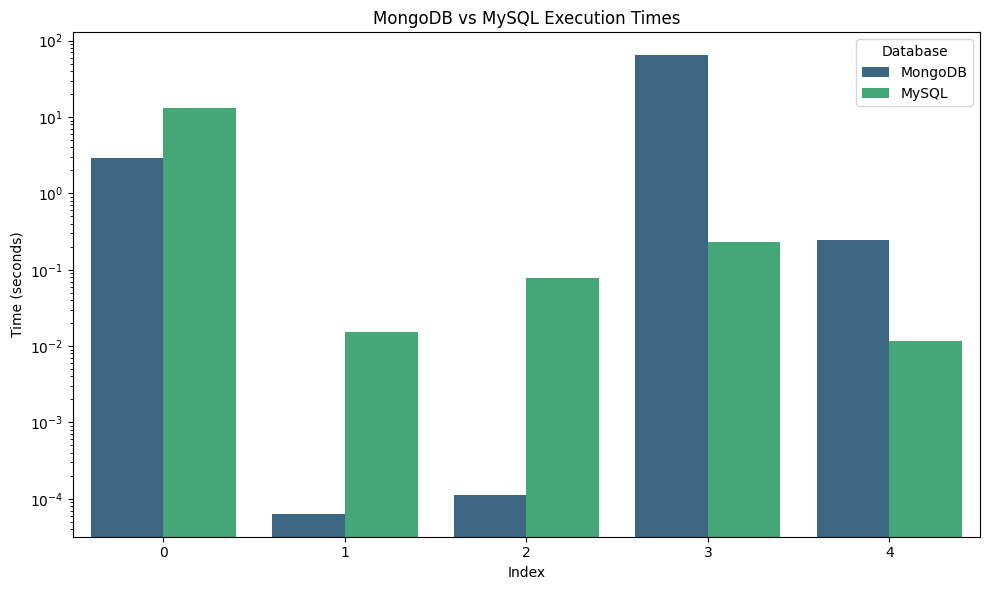

In [143]:
# Combine data into a DataFrame
data = pd.DataFrame({
    'Index': range(len(mongo_times)),
    'MongoDB': mongo_times,
    'MySQL': mysql_times
})
# Melt the DataFrame to plot later
melted_data = pd.melt(data, id_vars=['Index'], var_name='Database', value_name='Time')

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_data, x='Index', y='Time', hue='Database', palette='viridis')
plt.title('MongoDB vs MySQL Execution Times')
plt.ylabel('Time (seconds)')
plt.xlabel('Index')
plt.yscale('log')  # Use log scale for better visualization of the range
plt.legend(title='Database')
plt.tight_layout()
plt.show()

The first index is related to the population of the database. <br>
The others four are related to the queries. <br>
As we can see MongoDB has a better performance overall expect in third query that has the worst time. It needs 28 second to execute the query while MySQL takes less than half of a second.

## Phase 2


### MySQL

In [144]:
mysql_index_times = []

In [145]:
cursor = connection.cursor()
cursor.execute("CREATE INDEX gender_index ON users (gender);")
cursor.execute("CREATE INDEX merchant_state_index ON transactions (merchant_state);")
print("\nIndex on 'gender' and 'merchant_state' created.")
query = q3["query"]
# Query with the indexes
print("\nQuerying with index (gender = 'Female' and merchant_state):")
start_time = time.time()
cursor.execute(query)
results = cursor.fetchall()
index_time = time.time() - start_time
mysql_index_times.append(index_time)
print(f"Number of results: {len(results)}")
print(f"Query time with index: {index_time:.4f} seconds")
cursor.execute(f"EXPLAIN ANALYZE {query}")
explain_result_after = cursor.fetchall()
print("Explain output with index:")
for row in explain_result_after:
    print(row)


sqlShowIndexes = "show index from users"
cursor.execute(sqlShowIndexes)
indexList = cursor.fetchall()
print(indexList)
sqlShowIndexes = "show index from transactions"
cursor.execute(sqlShowIndexes)
indexList = cursor.fetchall()
print(indexList)

cursor.execute("DROP INDEX gender_index ON users;")
cursor.execute("DROP INDEX merchant_state_index ON transactions;")


Index on 'gender' and 'merchant_state' created.

Querying with index (gender = 'Female' and merchant_state):
Number of results: 0
Query time with index: 0.1063 seconds
Explain output with index:
("-> Insert into state_spending_summary\n    -> Table scan on <temporary>  (actual time=224..224 rows=59 loops=1)\n        -> Aggregate using temporary table  (actual time=224..224 rows=59 loops=1)\n            -> Nested loop inner join  (cost=22502 rows=25302) (actual time=0.0306..191 rows=25493 loops=1)\n                -> Filter: (T.client_id is not null)  (cost=5069 rows=49808) (actual time=0.0187..72 rows=50000 loops=1)\n                    -> Table scan on T  (cost=5069 rows=49808) (actual time=0.0171..65.6 rows=50000 loops=1)\n                -> Filter: (U.gender = 'Female')  (cost=0.25 rows=0.508) (actual time=0.00216..0.00222 rows=0.51 loops=50000)\n                    -> Single-row index lookup on U using PRIMARY (id=T.client_id)  (cost=0.25 rows=1) (actual time=0.00182..0.00185 rows

In [146]:
cursor.execute("CREATE INDEX card_on_dark_web_index ON cards (card_on_dark_web);")
cursor.execute("CREATE INDEX amount_index ON transactions (amount);")
print("\Index on 'card_on_dark_web' and 'amount' created.")
query = q4["query"]
# Query with the index
print("\nQuerying with index (card_on_dark_web = '1' and amount >1000):")
start_time = time.time()
cursor.execute(query)
results = cursor.fetchall()
index_time = time.time() - start_time
mysql_index_times.append(index_time)
print(f"Number of results: {len(results)}")
print(f"Query time with index: {index_time:.4f} seconds")
cursor.execute(f"EXPLAIN ANALYZE {query}")
explain_result_after = cursor.fetchall()
print("Explain output with index:")
for row in explain_result_after:
    print(row)


sqlShowIndexes = "show index from cards"
cursor.execute(sqlShowIndexes)
indexList = cursor.fetchall()
print(indexList)
sqlShowIndexes = "show index from transactions"
cursor.execute(sqlShowIndexes)
indexList = cursor.fetchall()
print(indexList)

cursor.execute("DROP INDEX card_on_dark_web_index ON cards;")
cursor.execute("DROP INDEX amount_index ON transactions;")

cursor.close()
connection.close()

\Index on 'card_on_dark_web' and 'amount' created.

Querying with index (card_on_dark_web = '1' and amount >1000):
Number of results: 0
Query time with index: 0.0040 seconds
Explain output with index:
('-> Update C (buffered)  (actual time=1.02..1.02 rows=0 loops=1)\n    -> Nested loop inner join  (cost=35.5 rows=2.2) (actual time=0.225..1.01 rows=10 loops=1)\n        -> Filter: ((T.amount > 1000) and (T.card_id is not null))  (cost=20.1 rows=44) (actual time=0.0577..0.51 rows=44 loops=1)\n            -> Index range scan on T using amount_index over (1000 < amount)  (cost=20.1 rows=44) (actual time=0.0526..0.45 rows=44 loops=1)\n        -> Filter: (C.card_on_dark_web = 1)  (cost=0.25 rows=0.05) (actual time=0.0107..0.0108 rows=0.227 loops=44)\n            -> Single-row index lookup on C using PRIMARY (id=T.card_id)  (cost=0.25 rows=1) (actual time=0.00967..0.00977 rows=1 loops=44)\n',)
[('cards', 0, 'PRIMARY', 1, 'id', 'A', 5670, None, None, '', 'BTREE', '', '', 'YES', None), ('cards',

### MongoDB

In [147]:
mongodb_index_times = []

In [148]:
def indexes_information(collection):
    indexes_info = collection.index_information()
    print(indexes_info)
indexes_information(users_collection)
indexes_information(cards_collection)
indexes_information(transactions_collection)

{'_id_': {'v': 2, 'key': [('_id', 1)]}}
{'_id_': {'v': 2, 'key': [('_id', 1)]}}
{'_id_': {'v': 2, 'key': [('_id', 1)]}}


In [149]:
import pprint
# Create an index on 'gender'
users_collection.create_index([("gender", ASCENDING)])
print("\nIndex on 'gender' created.")
print(users_collection.index_information())
# Create an index on 'merchant_state'
transactions_collection.create_index([("merchant_state", ASCENDING)])
print("\nIndex on 'merchant_state' created.")
print(transactions_collection.index_information())
query = mongo_q3
# Query with the index
print("\nQuerying with index:")
results = list(users_collection.aggregate(query))
print(f"Number of results: {len(results)}")
print("\nTime in millis:")
explain_output = db.command(
    'explain',
    {
    'aggregate': 'users',
    'pipeline': query,
    'cursor': {}
    },
    verbosity = 'executionStats'
    )
pprint.pprint(explain_output["stages"][0]["$cursor"]["executionStats"]["executionTimeMillis"])
time_s = explain_output["stages"][0]["$cursor"]["executionStats"]["executionTimeMillis"]
mongodb_index_times.append(time_s/1000)
# Drop index
users_collection.drop_index('gender_1')
transactions_collection.drop_index('merchant_state_1')


Index on 'gender' created.
{'_id_': {'v': 2, 'key': [('_id', 1)]}, 'gender_1': {'v': 2, 'key': [('gender', 1)]}}

Index on 'merchant_state' created.
{'_id_': {'v': 2, 'key': [('_id', 1)]}, 'merchant_state_1': {'v': 2, 'key': [('merchant_state', 1)]}}

Querying with index:
Number of results: 0

Time in millis:
2951


In [150]:
# Create an index on 'card_on_dark_web'
cards_collection.create_index([("card_on_dark_web", ASCENDING)])
print("\nIndex on 'card_on_dark_web' created.")
print(cards_collection.index_information())
# Create an index on 'amount'
transactions_collection.create_index([("amount", ASCENDING)])
print("\nIndex on 'amount' created.")
print(transactions_collection.index_information())
query = mongo_q4
# Query with the index
print("\nQuerying with index:")
results = list(cards_collection.aggregate(query))
print(f"Number of results: {len(results)}")
print("\nTime in millis:")
explain_output = db.command(
    'explain',
    {
    'aggregate': 'users',
    'pipeline': query,
    'cursor': {}
    },
    verbosity = 'executionStats'
    )
pprint.pprint(explain_output["stages"][0]["$cursor"]["executionStats"]["executionTimeMillis"])
time_s = explain_output["stages"][0]["$cursor"]["executionStats"]["executionTimeMillis"]
mongodb_index_times.append(time_s/1000)
# Drop index
cards_collection.drop_index('card_on_dark_web_1')
transactions_collection.drop_index('amount_1')


Index on 'card_on_dark_web' created.
{'_id_': {'v': 2, 'key': [('_id', 1)]}, 'card_on_dark_web_1': {'v': 2, 'key': [('card_on_dark_web', 1)]}}

Index on 'amount' created.
{'_id_': {'v': 2, 'key': [('_id', 1)]}, 'amount_1': {'v': 2, 'key': [('amount', 1)]}}

Querying with index:
Number of results: 0

Time in millis:
2


## Comparison

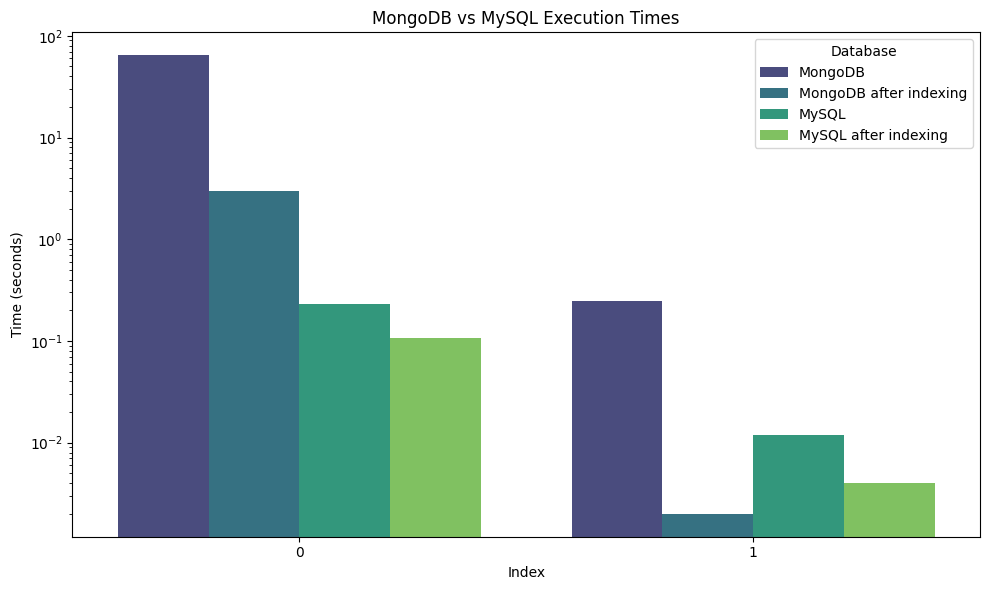

In [151]:
data = pd.DataFrame({
    'Index': range(len(mysql_index_times)),
    'MongoDB': mongo_times[-2:],
    'MongoDB after indexing': mongodb_index_times,
    'MySQL': mysql_times[-2:],
    'MySQL after indexing': mysql_index_times
})
# Melt the DataFrame to plot later
melted_data = pd.melt(data, id_vars=['Index'], var_name='Database', value_name='Time')
# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_data, x='Index', y='Time', hue='Database', palette='viridis')
plt.title('MongoDB vs MySQL Execution Times')
plt.ylabel('Time (seconds)')
plt.xlabel('Index')
plt.yscale('log')  # Use log scale for better visualization of the range
plt.legend(title='Database')
plt.tight_layout()
plt.show()

### Optimisation

Since in the first phase the third query was taking too long we decide to improve it.
We also wanted to display our progress adding our code below and report the difference in time.

In [152]:
mongo_q3_before_opt = [
    {"$match": {"gender": "Female"}},
    {"$lookup": {
        "from": "transactions",  
        "localField": "id",  
        "foreignField": "client_id",  
        "as": "user_transactions"  
    }},
    {"$unwind": "$user_transactions"},
    {"$group": {
        "_id": "$user_transactions.merchant_state",  
        "total_amount": {
            "$sum": {"$toDouble": "$user_transactions.amount"}  
        }
    }},
    {"$sort": {"total_amount": -1}},
    {"$limit": 100}
]
opt_times = []
start_time = time.time()
users_collection.aggregate(mongo_q3_before_opt)
end_time = time.time()
opt_times.append(end_time - start_time)

In [153]:
mongo_q3_after_opt = [
    {"$match": {"gender": "Female"}},  
    
    {"$lookup": {
        "from": "transactions",
        "localField": "id",
        "foreignField": "client_id",
        "as": "user_transactions"
    }},
    
    {"$match": {"user_transactions": {"$ne": []}}},  
    
    {"$unwind": "$user_transactions"},  
    
    {"$group": {
        "_id": "$user_transactions.merchant_state",
        "total_amount": {"$sum": {"$toDouble": "$user_transactions.amount"}}
    }},
    
    {"$sort": {"total_amount": -1}},
    
    {"$limit": 100}
]
start_time = time.time()
users_collection.aggregate(mongo_q3_after_opt)
end_time = time.time()
opt_times.append(end_time - start_time)

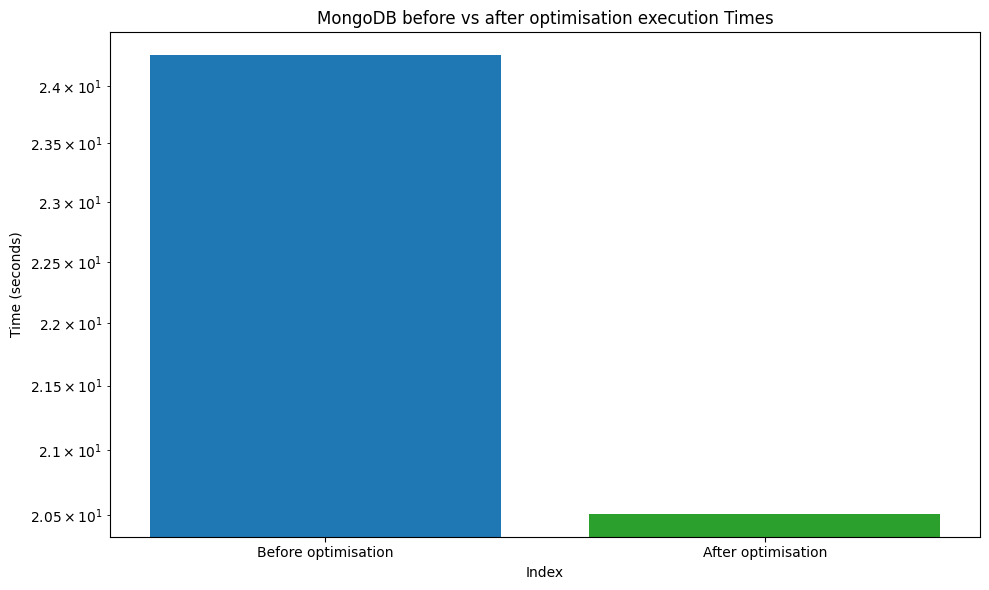

In [154]:
# Create the barplot
plt.figure(figsize=(10, 6))
plt.bar(['Before optimisation', 'After optimisation'], opt_times, color=['tab:blue', 'tab:green'])
plt.title('MongoDB before vs after optimisation execution Times')
plt.ylabel('Time (seconds)')
plt.xlabel('Index')
plt.yscale('log')  # Use log scale for better visualization of the range
plt.tight_layout()
plt.show()

We also show the graph for the query of the new table/schema created to show the improvement of the read operation from it.

We can see that after our solution MongoDB has a better performance.

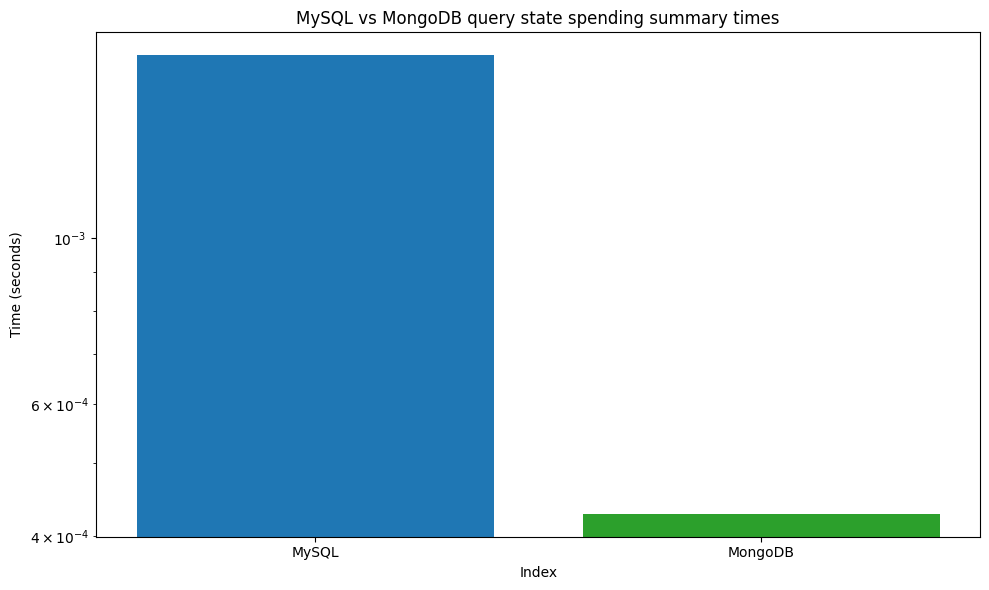

In [155]:
times_queries = []
times_queries.append(new_table_time)
times_queries.append(new_collection_time)
# Create the barplot
plt.figure(figsize=(10, 6))
plt.bar(['MySQL', 'MongoDB'], times_queries, color=['tab:blue', 'tab:green'])
plt.title('MySQL vs MongoDB query state spending summary times')
plt.ylabel('Time (seconds)')
plt.xlabel('Index')
plt.yscale('log')  # Use log scale for better visualization of the range
plt.tight_layout()
plt.show()